<a href="https://colab.research.google.com/github/cmliaa/spotify-song-recommender/blob/main/spotify_song_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
url = 'https://raw.githubusercontent.com/cmliaa/spotify-tracks/refs/heads/main/dataset.csv'
df = pd.read_csv(url)

In [30]:
from sklearn.preprocessing import StandardScaler
df = df.drop_duplicates(subset='track_id').reset_index(drop=True)

audio_features = [
    'danceability','energy','loudness','speechiness',
    'acousticness','instrumentalness','liveness',
    'valence','tempo'
]

X = df[audio_features]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)




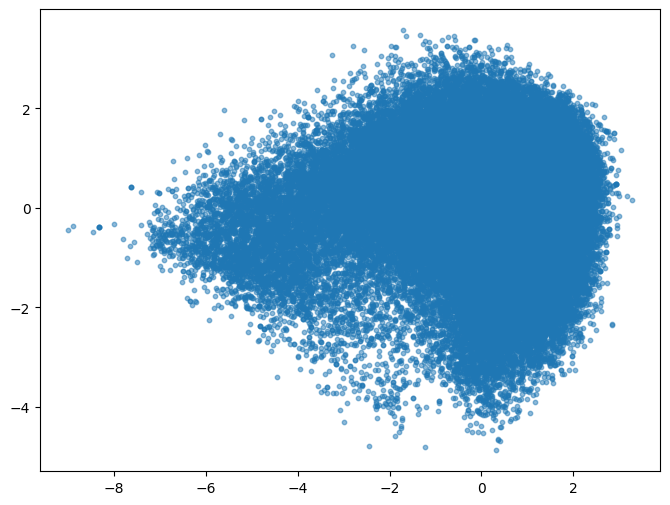

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, alpha=0.5)

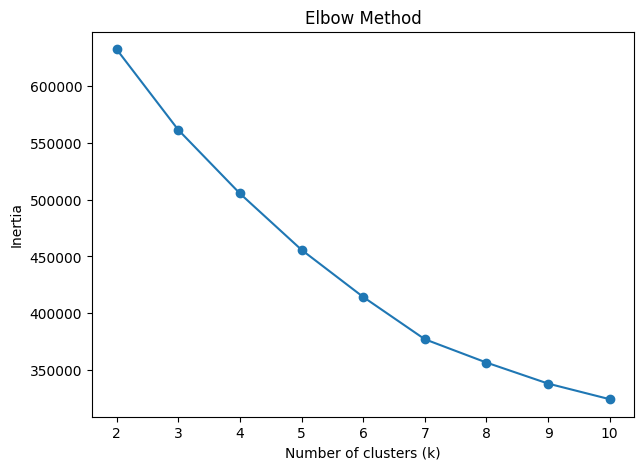

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7,5))
plt.plot(K, inertia, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()




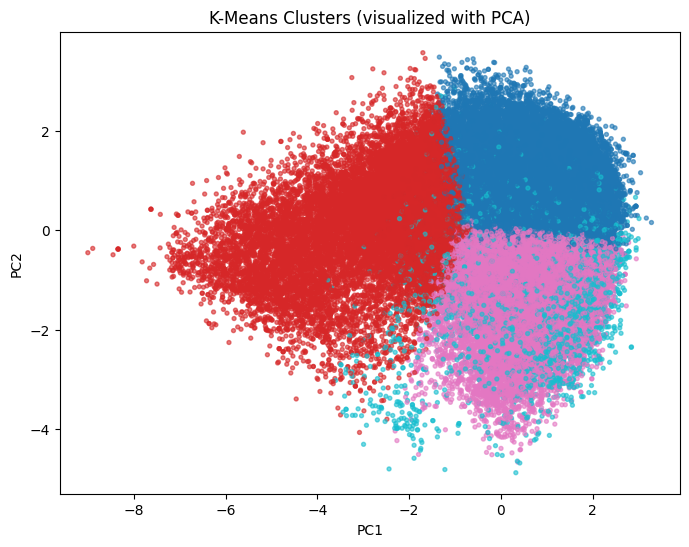

In [29]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = kmeans.fit_predict(scaled_features)

df['cluster'] = labels

plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=labels,
    cmap='tab10',
    s=8,
    alpha=0.6
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clusters (visualized with PCA)")
plt.show()


In [24]:
from sklearn.metrics.pairwise import cosine_similarity

def get_song_index(df, track_name, artists=None):
  if artists:
    matches = df[(df['track_name'].str.lower() == track_name.lower()) & (df['artists'].str.lower() == artists.lower())]
  else:
    matches = df[df['track_name'].str.lower() == track_name.lower()]

  if len(matches) == 0:
      raise ValueError("Song not found in dataset.")

  return matches.sort_values('popularity', ascending=False).index[0]

def rec_songs(df, scaled_features, track_name, artists=None, k=5):
    song_index = get_song_index(df, track_name, artists)

    print("Because you liked:")
    print(df.loc[song_index][['track_name', 'artists']])
    print("\n Recommended songs:\n")

    song_vector = scaled_features[song_index].reshape(1, -1)
    similarities = cosine_similarity(song_vector, scaled_features)[0]
    similar_indices = similarities.argsort()[::-1]
    top_indices = similar_indices[1:k+1]

    recommend = df.iloc[top_indices].copy()
    recommend['similarity'] = similarities[top_indices]
    recommend = recommend.sort_values(['similarity', 'popularity'], ascending=False)
    recommend = recommend[recommend['popularity'] > 20]
    return recommend[['track_name', 'artists', 'similarity', 'popularity']]


In [32]:
rec_songs(df, scaled_features, "Between the Bars", "Elliott Smith")


Because you liked:
track_name    Between The Bars
artists          Elliott Smith
Name: 49494, dtype: object

 Recommended songs:



,track_name,artists,similarity,popularity
4302,Evermore - Solo Piano Version,Alexis Ffrench,0.996629,25
4698,Princess Mononoke Lofi (The Legend of Ashitaka),Kato,0.994046,58
66412,As You Close Your Eyes,Elias Braun;Denis Turbide,0.992775,56
66281,Concepts,Ever So Blue,0.992438,53
